In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import os
import torchtext
import pyarrow

# Loading Gutenberg data and looking at trends
Trends include frequency distributions by genre, length of text

In [14]:
# Importing raw data folder to eventually read the file
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/winter_2024/advanced_ml/project/Talk BERTy to Me'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Reading the new training data file
data_gutenberg = pd.read_parquet(file_path+'/train.parquet')

In [ ]:
# Examining the new training data
print(f"Columns in dataset are: {data_gutenberg.columns.to_list()}")
print(f"Number of books: {len(data_gutenberg['title'].unique())}")
print("Let's look at first 5 random rows of the dataset")
print(data_gutenberg.head(5))

Columns in dataset are: ['title', 'text', 'genre_one_hot']
Number of books: 8508
Let's look at first 5 random rows of the dataset
                                   title  \
0                  the alchemists secret   
1                           blue jackets   
2                         four americans   
3                  the disowned complete   
4  wonderlijke avonturen van een chinees   

                                                text  \
0  Produced by Roger Frank and the Online Distrib...   
1  Produced by Nick Hodson of London, England\n\n...   
2  Produced by Martin Pettit and the Online Distr...   
3  Produced by Tapio Riikonen and David Widger\n\...   
4  Produced by Jeroen Hellingman and the Online D...   

                     genre_one_hot  
0                               []  
1           [fiction, non-fiction]  
2                        [fiction]  
3  [fiction, classics, historical]  
4              [fiction, classics]  


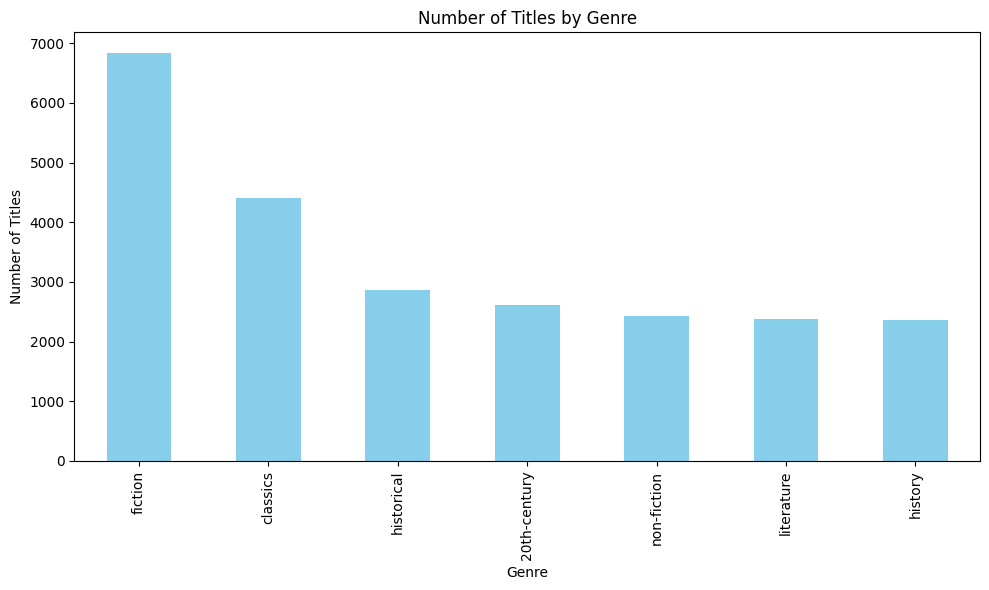

In [19]:
# Let's look distribution of titles across genres
genre_counts = data_gutenberg['genre_one_hot'].explode().value_counts()

# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Titles by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

In [21]:
# Now let's look at length of text distribution. First, let's check if there are rows with null values for text
# Count the number of rows with empty values in the 'text' column
num_empty_text = data_gutenberg['text'].isnull().sum()
print("Number of rows with empty values in the 'text' column:", num_empty_text)

Number of rows with empty values in the 'text' column: 212


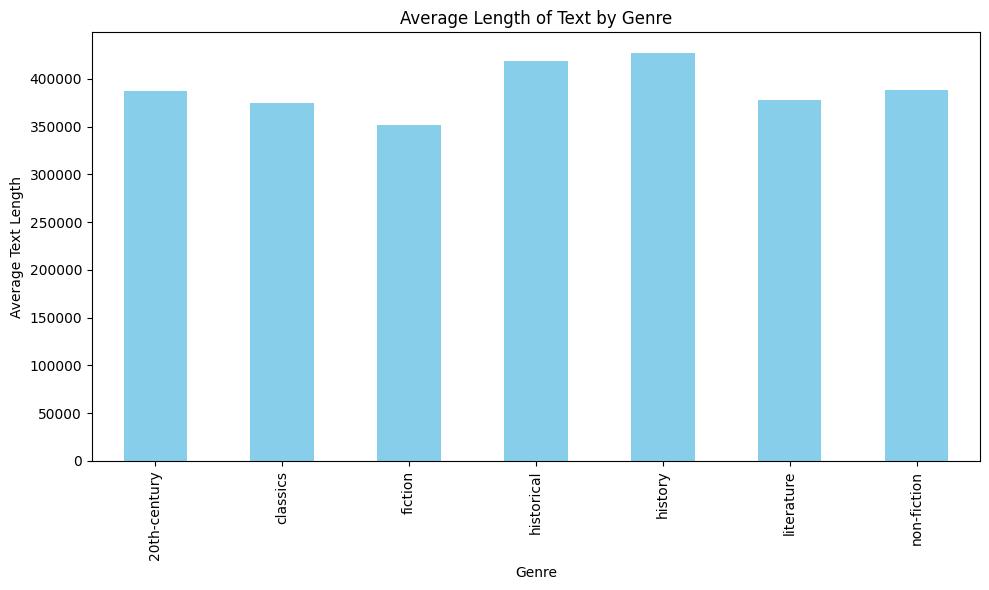

In [28]:
# Let's remove these 212 rows from the dataset and plot the distribution of remaining text lengths
data_gutenberg = data_gutenberg.dropna(subset=['text'])

# Calculate average text length for each genre
genre_avg_text_length = data_gutenberg.explode('genre_one_hot').groupby('genre_one_hot')['text'].apply(lambda x: x.str.len().mean())

# Plotting
plt.figure(figsize=(10, 6))
genre_avg_text_length.plot(kind='bar', color='skyblue')
plt.title('Average Length of Text by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Text Length')
plt.tight_layout()
plt.show()

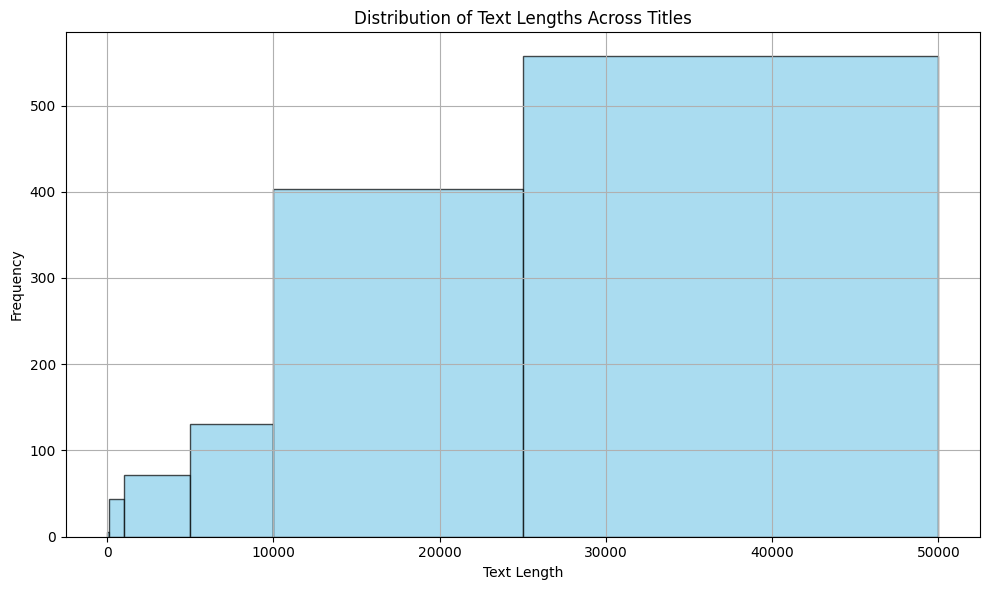

In [47]:
# Plotting to check if there are outliers in terms of length- books that are too small.
# Define bins with different intervals
bins = [0, 100, 1000, 5000, 10000, 25000, 50000]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(data_gutenberg['text_length'], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Lengths Across Titles')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
#plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

## Next steps:
1. Remove ~200 books that have less than 10,000 words/tokens
2. Remove non-English books. For that, we first need to add the column that tells us a title's language

# Preprocessing
Source tutorial link: https://huggingface.co/learn/nlp-course/chapter7/5

In [49]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [59]:
# Function to create sequence pairs for generation (source, target) format
# By doing this, we will be fine-tuning our model as a Language Model - may want to revisit this approach

from torchtext.data.utils import get_tokenizer

def create_seq2seq_labels(text, window_size=8):
    if text is None:
        return []
    tokenizer = get_tokenizer("basic_english") # should we use the GPT2Tokenizer here? Need to check and compare results
    tokens = tokenizer(text)
    sequence_pairs = []
    for idx in range(len(tokens) - window_size):
        sequence_pairs.append(
            (tokens[idx : idx + window_size], tokens[idx + 1 : idx + window_size + 1])
        )
    return sequence_pairs

In [68]:
# Creating source and target pairs
sampled_gutenberg = data_gutenberg.head(5)
print(sampled_gutenberg)
sampled_gutenberg.loc[:, "seq_pairs"] = sampled_gutenberg["text"].apply(create_seq2seq_labels)
sampled_gutenberg.drop(columns=["text","text_length"], inplace=True)
sampled_gutenberg = sampled_gutenberg.explode("seq_pairs").reset_index(drop=True)
print(sampled_gutenberg.columns)

                                   title  \
0                  the alchemists secret   
1                           blue jackets   
2                         four americans   
3                  the disowned complete   
4  wonderlijke avonturen van een chinees   

                                                text  \
0  Produced by Roger Frank and the Online Distrib...   
1  Produced by Nick Hodson of London, England\n\n...   
2  Produced by Martin Pettit and the Online Distr...   
3  Produced by Tapio Riikonen and David Widger\n\...   
4  Produced by Jeroen Hellingman and the Online D...   

                     genre_one_hot  text_length  
0                               []       188561  
1           [fiction, non-fiction]       645382  
2                        [fiction]       102615  
3  [fiction, classics, historical]       996609  
4              [fiction, classics]       422877  


<ipython-input-68-79cd29c4f122>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_gutenberg.loc[:, "seq_pairs"] = sampled_gutenberg["text"].apply(create_seq2seq_labels)
<ipython-input-68-79cd29c4f122>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_gutenberg.drop(columns=["text","text_length"], inplace=True)


Index(['title', 'genre_one_hot', 'seq_pairs'], dtype='object')


In [73]:
# Checking one source-sample pair to check it works properly
print(sampled_gutenberg['seq_pairs'][0])
print(sampled_gutenberg['seq_pairs'][1])

(['produced', 'by', 'roger', 'frank', 'and', 'the', 'online', 'distributed'], ['by', 'roger', 'frank', 'and', 'the', 'online', 'distributed', 'proofreading'])
(['by', 'roger', 'frank', 'and', 'the', 'online', 'distributed', 'proofreading'], ['roger', 'frank', 'and', 'the', 'online', 'distributed', 'proofreading', 'team'])


In [72]:
# Examining the sampled dataframe for a given book
book_title = 'the alchemists secret'
rows_for_first_book = sampled_gutenberg[sampled_gutenberg['title'] == book_title]
print(rows_for_first_book)

                       title genre_one_hot  \
0      the alchemists secret            []   
1      the alchemists secret            []   
2      the alchemists secret            []   
3      the alchemists secret            []   
4      the alchemists secret            []   
...                      ...           ...   
40944  the alchemists secret            []   
40945  the alchemists secret            []   
40946  the alchemists secret            []   
40947  the alchemists secret            []   
40948  the alchemists secret            []   

                                               seq_pairs  
0      ([produced, by, roger, frank, and, the, online...  
1      ([by, roger, frank, and, the, online, distribu...  
2      ([roger, frank, and, the, online, distributed,...  
3      ([frank, and, the, online, distributed, proofr...  
4      ([and, the, online, distributed, proofreading,...  
...                                                  ...  
40944  ([gutenberg, ', s, the, alc

Next steps Produce GPT-2 compatible inputs, run the model on a small sample and check results